# Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"

Nhóm 2:
1. 18120625 - Nguyễn Trần Trung - [Trung-Rei](https://github.com/Trung-Rei)
2. 18120658 - Phạm Viết Xuân - [PhamVietXuan](https://github.com/PhamVietXuan)
3. 1712698 - Võ Văn Quân - [quanvovan](https://github.com/quanvovan)
4. 1712160 - Hà Thị Ngọc Thắm - [Thamha09081999](https://github.com/Thamha09081999)

Link thùng chứa Github của nhóm: [link](https://github.com/Trung-Rei/kaggle-porto-seguro)

## Mô tả bài toán

Bảo hiểm là một thứ bắt buộc khi mua một chiếc xe ô tô. Thông thường, mức chi phí đóng bảo hiểm sẽ bằng nhau. Nhưng có những người chạy xe cẩn thận, cũng có người chạy xe hay va chạm khiến cho chi phí đóng bảo hiểm cho người người như vậy không công bằng. Như vậy, cần có một mức giá khác nhau cho những người lái xe khác nhau để công bằng với khách hàng cũng như công ty bảo hiểm.

Porto Seguro - Một công ty bảo hiểm lớn ở Brazil yêu cầu một mô hình học máy tốt để dự đoán **xác suất yêu cầu bồi thường** của chủ xe nhằm đưa ra mức giá bảo hiểm hợp lý hơn.

Input/Output:
* Input: Dữ liệu lịch sử được công ty thu thập từ chủ ô tô (chủ hợp đồng bảo hiểm) từ các năm trước.
* Output: Xác suất chủ xe đó yêu cầu bồi thường bảo hiểm. Giá trị từ 0 - 1; càng về 0 có nghĩa khả năng cao chủ ô tô đó sẽ không yêu cầu bồi thường cho năm sau; càng về 1 nghĩa là chủ xe khả năng cao năm sau đòi bồi thường bảo hiểm.

Link bài toán: [Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview)

### Độ đo đánh giá

* Metric: Normalized Gini Coefficient
* Cách tính: `2 * AUC – 1`
* Giá trị trong khoảng **(0, 1)**: càng về 1 mô hình càng tốt
* Phù hợp với bài toán phân lớp nhị phân và dữ liệu mất cân bằng nghiêm trọng (Giống **AUC**).

Giải thích cụ thể về **Normalized Gini Coefficient**: [link](https://medium.com/analytics-vidhya/porto-seguros-safe-driver-prediction-a-machine-learning-case-study-1f2dd3f79d9e)

## Giải quyết bài toán

### Import thư viện

In [17]:
#import lightgbm as lgbm
from scipy import sparse as ssp
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7,7)

### Tổng quan dữ liệu

Thông tin dữ liệu từ cuộc thi được bảo mật nên tên các đặc trưng được thay thế bằng tên ẩn danh.

Các thông tin được cuộc thi cung cấp:
* Đặc trưng được chia làm 4 nhóm chính:
    * `ind` (individual): các đặc trưng liên quan đến người lái xe.
    * `reg` (region): các đặc trưng về khu vực người đó chạy xe.
    * `car` (car): các đặc trưng thông số của ô tô.
    * `calc` (calculated): các đặc trưng đã được tính toán.
* Hậu tố `cat` cho đặc trưng **categorical**, `bin` cho đặc trưng **nhị phân**, không có hậu tố chỉ những đặc trưng **ordinal** hoặc **continuous**.
* Giá trị `-1` đại diện cho dữ liệu tại đó bị thiếu.
* Cột `target`: gồm giá trị 1 và 0 thể hiện chủ xe đó có đưa ra yêu cầu bồi thường hay không.

In [4]:
path = "../../../data/"

train = pd.read_csv(path+'train.csv')
train_label = train['target']
train_id = train['id']
test = pd.read_csv(path+'test.csv')
test_id = test['id']

In [7]:
train.sample(5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
187989,469930,0,1,1,5,0,4,0,0,1,...,2,0,5,7,0,1,1,0,0,0
316868,791878,0,2,1,3,1,0,0,0,0,...,5,1,3,8,0,0,0,1,0,0
312774,781606,0,0,1,6,1,6,0,0,0,...,2,1,5,7,0,1,1,0,0,0
127837,319624,0,1,2,5,0,0,1,0,0,...,6,4,1,6,0,1,1,1,0,0
397037,991982,0,6,2,6,1,0,0,1,0,...,8,3,5,9,0,1,1,0,0,0


In [8]:
train.shape

(595212, 59)

In [9]:
test.shape

(892816, 58)

In [10]:
train.drop_duplicates()
train.shape

(595212, 59)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

* Tập **train** có 59 cột, tập **test** có 58 cột (không có cột `target`)
* Tập **train** không có dòng trùng nhau.
* Toàn bộ dữ liệu đều ở dạng số.

### Feature engineer + Khám phá dữ liệu

Cho cả 2 mô hình **LightGBM** và **Neural networks**

Bao gồm:
* Loại bỏ tất cả đặc trưng `calc`
* Thêm đặc trưng: Số lượng giá trị thiếu mỗi dòng
* Mã hóa one hot với các đặc trưng `cat`
* Gộp các đặc trưng `ind` làm một: `new_ind`
* Đếm các đặc trưng `cat` kể cả `new_ind`

0    0.963552
1    0.036448
Name: target, dtype: float64


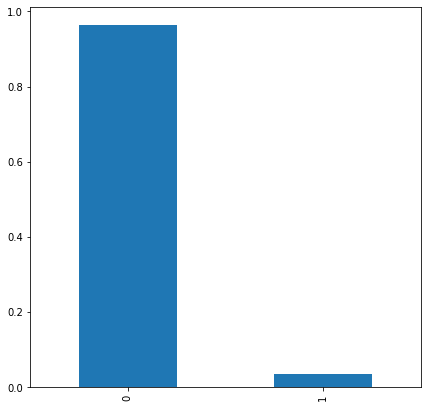

In [19]:
cls_ratio = train_label.value_counts()/train_label.count()
print(cls_ratio)
cls_ratio.plot.bar()
plt.show()

Dữ liệu mất cân bằng nghiêm trọng với `96.3%` lớp 0 và `3.6%` lớp 1.

#### Loại bỏ các đặc trưng `calc`

Các đặc trưng `calc` được loại bỏ vì tác giả thấy chúng không đóng góp gì cho model qua các thử nghiệm.

In [20]:
y = train['target'].values
drop_feature = [
    'id',
    'target'
]

X = train.drop(drop_feature,axis=1)
feature_names = X.columns.tolist()
cat_features = [c for c in feature_names if ('cat' in c and 'count' not in c)]
num_features = [c for c in feature_names if ('cat' not in c and 'calc' not in c)]

In [27]:
cat_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [26]:
num_features

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15']

#### Đếm số lượng giá trị thiếu mỗi dòng

Thêm cột `missing`: số lượng giá trị thiếu của mỗi dòng dữ liệu.

In [21]:
train['missing'] = (train==-1).sum(axis=1).astype(float)
test['missing'] = (test==-1).sum(axis=1).astype(float)
num_features.append('missing')

In [22]:
train["missing"].value_counts()

2.0    254982
1.0    156295
0.0    124931
3.0     56042
4.0      2883
7.0        53
6.0        19
8.0         7
Name: missing, dtype: int64

#### Chuyển các đặc trưng categorical sang dạng `one hot`

Các trị null `-1` không được **impute** (điền giá trị mean hoặc mode) mà được xem như là một **giá trị categorical** và được encode.

In [23]:
for c in cat_features:
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

enc = OneHotEncoder()
enc.fit(train[cat_features])
X_cat = enc.transform(train[cat_features])
X_t_cat = enc.transform(test[cat_features])

#### Gộp các đặc trưng `ind` làm một

Các đặc trưng `ind` được gộp thành một đặc trưng mới: `new_ind`.

Như vậy, các dòng có bộ giá trị đặc trưng từ `ind_01` đến `ind_18` giống nhau sẽ có giá trị `new_ind` cũng giống nhau.

In [28]:
ind_features = [c for c in feature_names if 'ind' in c]
count=0
for c in ind_features:
    if count==0:
        train['new_ind'] = train[c].astype(str)+'_'
        test['new_ind'] = test[c].astype(str)+'_'
        count+=1
    else:
        train['new_ind'] += train[c].astype(str)+'_'
        test['new_ind'] += test[c].astype(str)+'_'

In [29]:
train["new_ind"]

0          2_2_5_2_1_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_1_1_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_2_1_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_1_1_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_2_1_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
595207    3_1_10_1_1_0_0_0_1_0_0_0_0_0_13_1_0_0_
595208      5_1_3_1_1_0_0_0_1_0_0_0_0_0_6_1_0_0_
595209    1_1_10_1_1_1_0_0_0_0_0_0_0_0_12_1_0_0_
595210     5_2_3_2_1_0_0_1_0_0_0_0_0_0_12_1_0_0_
595211      0_1_8_1_1_1_0_0_0_0_0_0_0_0_7_1_0_0_
Name: new_ind, Length: 595212, dtype: object

#### Đếm các đặc trưng `cat` kể cả `new_ind`

* Đếm số lượng giá trị của các đặc trưng `cat` và đưa làm đặc trưng mới (hậu tố `_count`).
* Số lượng được đếm trên bộ dữ liệu gộp giữa **train** và **test** -> Để có số liệu thống kê tổng quát hơn.

In [30]:
cat_count_features = []
for c in cat_features+['new_ind']:
    d = pd.concat([train[c],test[c]]).value_counts().to_dict()
    train['%s_count'%c] = train[c].apply(lambda x:d.get(x,0))
    test['%s_count'%c] = test[c].apply(lambda x:d.get(x,0))
    cat_count_features.append('%s_count'%c)

In [31]:
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'new_ind_count']

### Feature engineer + Khám phá dữ liệu 2

Các feature engineering thêm cho mô hình **Neural networks**.

### Kế hoạch tiếp theo

* a
* b

## Nhìn lại quá trình làm đồ án

## Tài liệu tham khảo